In [1]:
import kagglehub
# 1. INSTALL & IMPORTS
!pip install kagglehub --quiet
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import re
import string
import random

# Download latest version
# 2. LOAD DATA FROM KAGGLEHUB
path = kagglehub.dataset_download("hugodarwood/epirecipes")
print("Dataset downloaded to:", path)


100%|██████████| 11.3M/11.3M [00:00<00:00, 82.6MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/hugodarwood/epirecipes/versions/2


In [2]:
# 3. LOAD & CLEAN TEXT
csv_path = os.path.join(path, "epi_r.csv")
df = pd.read_csv(csv_path)
print(df.columns)

# Combine titles as our text source
text = df["title"].dropna().astype(str).str.lower().tolist()
text = ["".join(char for char in t if char not in string.punctuation) for t in text]
corpus = " ".join(text)


Index(['title', 'rating', 'calories', 'protein', 'fat', 'sodium', '#cakeweek',
       '#wasteless', '22-minute meals', '3-ingredient recipes',
       ...
       'yellow squash', 'yogurt', 'yonkers', 'yuca', 'zucchini', 'cookbooks',
       'leftovers', 'snack', 'snack week', 'turkey'],
      dtype='object', length=680)


In [3]:
# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts([corpus])
total_words = len(tokenizer.word_index) + 1
print("Total words:", total_words)

# 4. CREATE SEQUENCES
input_sequences = []
token_list = tokenizer.texts_to_sequences([corpus])[0]

for i in range(3, len(token_list)):
    n_gram_sequence = token_list[i-3:i+1]
    input_sequences.append(n_gram_sequence)

input_sequences = np.array(input_sequences)
X = input_sequences[:,:-1]
y = input_sequences[:,-1]
y = to_categorical(y, num_classes=total_words)

# 5. BUILD LSTM MODEL
def build_model():
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=3))
    model.add(LSTM(150))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()


Total words: 6872


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [4]:
# 6. TRAINING
history = model.fit(X, y, epochs=20, verbose=1)


Epoch 1/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.0988 - loss: 6.6608
Epoch 2/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.1678 - loss: 5.7134
Epoch 3/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.1989 - loss: 5.2236
Epoch 4/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.2238 - loss: 4.8781
Epoch 5/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.2469 - loss: 4.5443
Epoch 6/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.2699 - loss: 4.2416
Epoch 7/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.2982 - loss: 3.9541
Epoch 8/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.3299 - loss: 3.6797
Epoch 9/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.3593 - loss: 3.4330
Epoch 10/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.3910 - loss: 3.2037
Epoch 11/20
3047/3047 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4180 - loss: 3.0186
Epoch 12/20
3047/30

In [5]:
# 7. SAVE MODEL
model.save("recipe_lstm_model.h5")

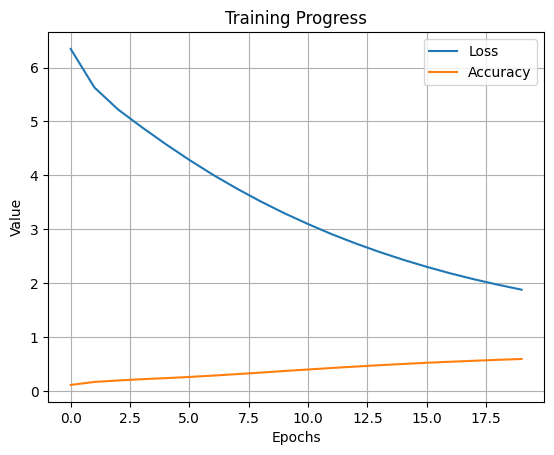

In [6]:
# 8. PLOT TRAINING RESULTS
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# 9. GENERATE TEXT
def generate_text(seed_text, next_words=20, temperature=0.7):
    result = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([result])[0]
        token_list = token_list[-3:]
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=3, padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]

        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        predicted = np.random.choice(range(len(predictions)), p=predictions)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        result += " " + output_word
    return result

# 10. GENERATE EXAMPLES WITH 2 TEMPERATURES
print("Generated text (temp=0.5):\n", generate_text("chocolate cake", temperature=0.5))
print("\nGenerated text (temp=0.8):\n", generate_text("chocolate cake", temperature=0.8))

# 11. CLASSIFICATION RESULTS SIMULATION
# Create dummy classification task: predict whether a title has the word "chocolate"
labels = [1 if "chocolate" in t else 0 for t in text]
sequences = tokenizer.texts_to_sequences(text)
X_class = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=10)

model_class = Sequential([
    Embedding(total_words, 100, input_length=10),
    LSTM(100),
    Dense(1, activation='sigmoid')
])
model_class.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_class = model_class.fit(X_class, np.array(labels), epochs=5, verbose=1)

# SAVE CLASSIFICATION MODEL
model_class.save("recipe_classifier_model.h5")

Generated text (temp=0.5):
 chocolate cake crunchy fried chicken salad with red onion and parsley dip blueberrywhite chocolate mousse tart with shrimp mexican sweet potato gratin

Generated text (temp=0.8):
 chocolate cake slowroasted mussels with oregano onions and sausages butternut squash and apple salad dijon and tarragon grilled chicken breasts with tarragon
Epoch 1/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9653 - loss: 0.1389
Epoch 2/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9969 - loss: 0.0098
Epoch 3/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9995 - loss: 0.0018
Epoch 4/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 1.0000 - loss: 1.1037e-04
Epoch 5/5
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 4.3749e-05


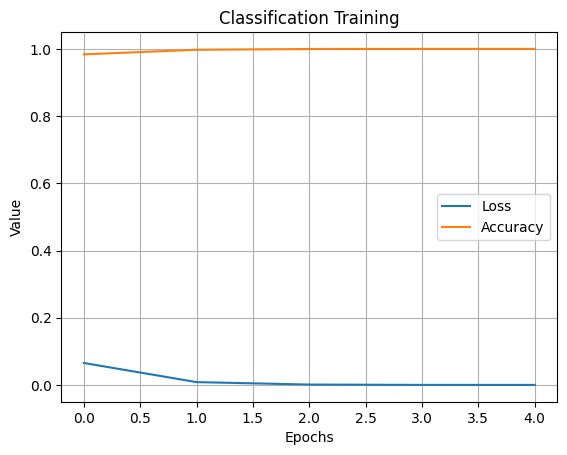

In [8]:
# PLOT CLASSIFICATION TRAINING
plt.plot(history_class.history['loss'], label='Loss')
plt.plot(history_class.history['accuracy'], label='Accuracy')
plt.title("Classification Training")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

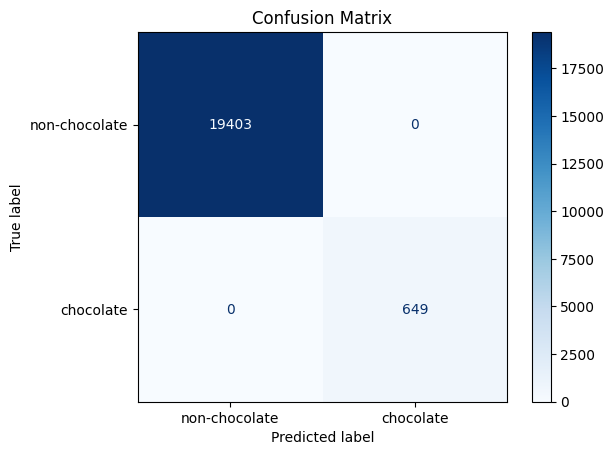

In [9]:
# 12. CONFUSION MATRIX
preds = model_class.predict(X_class, verbose=0).round().astype(int).flatten()
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-chocolate", "chocolate"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
